# Del 1

#### 1. Beskriv kort hur en relationsdatabas fungerar

En relationsdatabas där man kan lagra data i tabeller som är relaterade till varandra med hjälp av primärnycklar (som är unika för varje rad) och främmande nycklar (som skapar förhållanden mellan tabeller). På så sätt kan man skapa små tabeller och därmed reducera redundans och komplexiteten. Man använder SQL för att interagera med en sådan databas.

#### 2. Vad menas med “CRUD”-flödet?

CRUD står för Create (lägga till information), Read (läsa), Update (uppdatera) och Delete (radera). Det är de fyra grundläggande operationerna som man ska kunna utföra på data i en relationsdatabas.

#### 3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?

En left join hämtar alla rader från den första tabellen och alla rader från den andra tabellen som har ett matchande värde i den första tabellen. En inner join däremot hämtar BARA rader från den första tabellen som har ett matchande värde i den andra tabellen. Man använder det för att kunna kombinera data från två tabeller baserat på ett gemensamt fält.

#### 4. Beskriv kort vad indexering i SQL innebär.

Indexering används för att snabba upp sökningar i en db. Ett index skapas på en eller flera kolumner för att göra det enklare att hitta specifika rader utan att behöva söka igenom hela tabellen.

#### 6. Beskriv kort vad en vy i SQL är.

En vy i SQL är som en låtsastabell som visar data från en eller flera tabeller. Den gör det lättare att arbeta med data utan att ändra något i de riktiga tabellerna.

#### 7. Beskriv kort vad en lagrad procedur i SQL är.
En lagrad procedur i SQL är ett sparat program i SQL-kod som kan köras när som helst för att utföra en uppgift i DB.


In [ ]:
#!pip install sqlalchemy pandas tabulate matplotlib ipykernel jupyter notebook pyodbc

In [2]:
from sqlalchemy import create_engine
import pandas as pd

# Connection parameters
server = "OMEN"
database = "AdventureWorks2022"

# Connection string for Windows Authentication
connection_string = (
    f"mssql+pyodbc://@{server}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Test connection
try:
    with engine.connect() as connection:
        print("I am connected!")
except Exception as e:
    print("Something unexpected happened:", e)


I am connected!


#### Först utforskar jag strukturen av db AdventureWorks2022


In [4]:

query = "SELECT * FROM INFORMATION_SCHEMA.TABLES"
df = pd.read_sql(query, engine)
print(df.to_markdown())


|    | TABLE_CATALOG      | TABLE_SCHEMA   | TABLE_NAME                            | TABLE_TYPE   |
|---:|:-------------------|:---------------|:--------------------------------------|:-------------|
|  0 | AdventureWorks2022 | Sales          | SalesTaxRate                          | BASE TABLE   |
|  1 | AdventureWorks2022 | Sales          | PersonCreditCard                      | BASE TABLE   |
|  2 | AdventureWorks2022 | Person         | vAdditionalContactInfo                | VIEW         |
|  3 | AdventureWorks2022 | Person         | PersonPhone                           | BASE TABLE   |
|  4 | AdventureWorks2022 | HumanResources | vEmployee                             | VIEW         |
|  5 | AdventureWorks2022 | Sales          | SalesTerritory                        | BASE TABLE   |
|  6 | AdventureWorks2022 | HumanResources | vEmployeeDepartment                   | VIEW         |
|  7 | AdventureWorks2022 | Person         | PhoneNumberType                       | BASE TABLE   |


#### Det finns 90 tabeller i db:n som är uppdelade i scheman. Nu vill jag veta hur många scheman det finns. Dessutom finns det View tabeller som inte är riktiga tabeller utan bara visar data från andra tabeller. Base tabeller är de som innehåller data.



#### Hur många scheman finns det i databasen?
#### och vilka är de?

In [34]:


query = "SELECT COUNT(*) FROM INFORMATION_SCHEMA.SCHEMATA"
df = pd.read_sql(query, engine)
print(df)


query = "SELECT SCHEMA_NAME, SCHEMA_OWNER FROM INFORMATION_SCHEMA.SCHEMATA"
df = pd.read_sql(query, engine)
print(df.to_markdown())


     
0  18
|    | SCHEMA_NAME        | SCHEMA_OWNER       |
|---:|:-------------------|:-------------------|
|  0 | dbo                | dbo                |
|  1 | guest              | guest              |
|  2 | INFORMATION_SCHEMA | INFORMATION_SCHEMA |
|  3 | sys                | sys                |
|  4 | HumanResources     | dbo                |
|  5 | Person             | dbo                |
|  6 | Production         | dbo                |
|  7 | Purchasing         | dbo                |
|  8 | Sales              | dbo                |
|  9 | db_owner           | db_owner           |
| 10 | db_accessadmin     | db_accessadmin     |
| 11 | db_securityadmin   | db_securityadmin   |
| 12 | db_ddladmin        | db_ddladmin        |
| 13 | db_backupoperator  | db_backupoperator  |
| 14 | db_datareader      | db_datareader      |
| 15 | db_datawriter      | db_datawriter      |
| 16 | db_denydatareader  | db_denydatareader  |
| 17 | db_denydatawriter  | db_denydatawriter  |


#### Här ser vi att det finns 18 sheman. Det som vi är intresserade av är de 5 scheman nämligen humanresources, production, sales, person och purchasing.

#### Scheman som börjar med db_ samt sys och INFORMATION_SCHEMA är inte relevanta då de hanterar säkerhet, metadata eller systemoperationer.

#### med hjälp av information_schema.columns kan jag se bl.a. vilka typer av data innehåller tabellerna och hur många kolumner det finns i varje tabell och annan metadata


In [284]:

query = "SELECT TOP 10 TABLE_NAME, COLUMN_NAME, DATA_TYPE, CHARACTER_MAXIMUM_LENGTH FROM INFORMATION_SCHEMA.COLUMNS"
df = pd.read_sql(query, engine)
print(df.to_markdown())


|    | TABLE_NAME       | COLUMN_NAME      | DATA_TYPE        |   CHARACTER_MAXIMUM_LENGTH |
|---:|:-----------------|:-----------------|:-----------------|---------------------------:|
|  0 | SalesTaxRate     | SalesTaxRateID   | int              |                        nan |
|  1 | SalesTaxRate     | StateProvinceID  | int              |                        nan |
|  2 | SalesTaxRate     | TaxType          | tinyint          |                        nan |
|  3 | SalesTaxRate     | TaxRate          | smallmoney       |                        nan |
|  4 | SalesTaxRate     | Name             | nvarchar         |                         50 |
|  5 | SalesTaxRate     | rowguid          | uniqueidentifier |                        nan |
|  6 | SalesTaxRate     | ModifiedDate     | datetime         |                        nan |
|  7 | PersonCreditCard | BusinessEntityID | int              |                        nan |
|  8 | PersonCreditCard | CreditCardID     | int              |       


#### vi kan analysera kunddata
#### t.ex. skapa ett stapeldiagram för antal kunder per territorium

|    |   TerritoryID |   CustomerCount | TerritoryName   |
|---:|--------------:|----------------:|:----------------|
|  0 |             4 |            4696 | Southwest       |
|  1 |             9 |            3665 | Australia       |
|  2 |             1 |            3520 | Northwest       |
|  3 |            10 |            1991 | United Kingdom  |
|  4 |             7 |            1884 | France          |
|  5 |             8 |            1852 | Germany         |
|  6 |             6 |            1791 | Canada          |
|  7 |             5 |             176 | Southeast       |
|  8 |             3 |             132 | Central         |
|  9 |             2 |             113 | Northeast       |


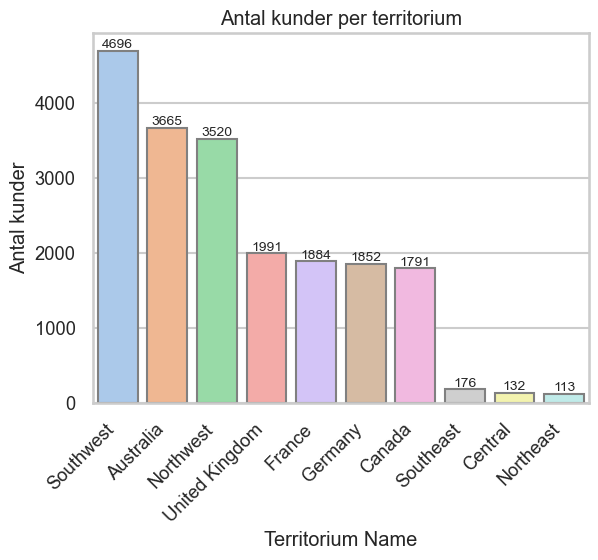

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT c.TerritoryID, COUNT(*) AS CustomerCount, st.Name AS TerritoryName
FROM sales.customer c
LEFT JOIN sales.salesterritory st
ON c.TerritoryID = st.TerritoryID
GROUP BY c.TerritoryID, st.Name
ORDER BY CustomerCount DESC;
"""
df = pd.read_sql(query, engine)
print(df.to_markdown())


# med hjälp av sns kan man ställa in ett trevligt tema för plotten
#https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_theme(context='talk', style='whitegrid', font='sans-serif', font_scale=0.8)


plt.figure()
bar_plot = sns.barplot(
    x='TerritoryName', 
    y='CustomerCount', 
    data=df, 
    palette="pastel",
    hue='TerritoryName',
    edgecolor="gray"
)


plt.xlabel('Territorium Name')
plt.ylabel('Antal kunder')
plt.title('Antal kunder per territorium')

#får texten att synas överst på stapeln
for index, row in df.iterrows():
    plt.text(row.name, row.CustomerCount, row.CustomerCount, ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.show()


#### De flesta kunder kommer från Southwest i USA. Det är kanske där vi ska anlägga vår nya fabrik.

#### Jag vet fortfarande inte vad företaget säljer.
#### Därför ska jag skapa ett cirkeldiagram för produktkategorier

|    | CategoryName   |   ProductCount |
|---:|:---------------|---------------:|
|  0 | Components     |             43 |
|  1 | Bikes          |             32 |
|  2 | Clothing       |             22 |
|  3 | Accessories    |              8 |


Text(0.5, 1.0, 'Product Categories Distribution')

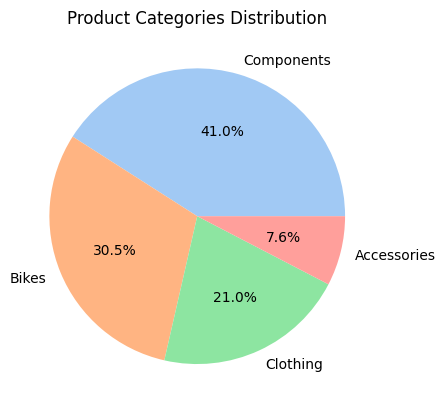

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT pc.Name AS CategoryName, COUNT(*) AS ProductCount
FROM production.product p
JOIN production.ProductCategory pc 
ON p.ProductSubcategoryID = pc.ProductCategoryID 
GROUP BY pc.Name
ORDER BY ProductCount DESC;
"""
df = pd.read_sql(query, engine)
print(df.to_markdown())


plt.figure()

plt.pie(
    x=df['ProductCount'],
    labels=df['CategoryName'],
    colors=sns.color_palette("pastel"),
    autopct='%1.1f%%',
    textprops={'fontsize': 10}
)
plt.title('Product Categories Distribution')


#### Bikes och Components är de produktkategorier som företaget fokuserar mest på. Lite mindre på kläder och accessories.


#### hur mycket känner företaget per år? 
#### det går att visualisera försäljningen över tid med hjälp av en linjediagram men också andra diagram t.ex. ett stapeldiagram


|    |   OrderYear |   TotalSales |
|---:|------------:|-------------:|
|  0 |        2011 |  1.26417e+07 |
|  1 |        2012 |  3.35243e+07 |
|  2 |        2013 |  4.36225e+07 |
|  3 |        2014 |  2.00579e+07 |


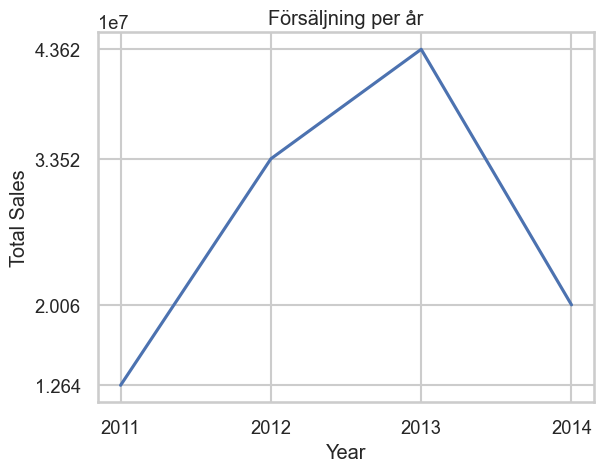

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

query = """ SELECT YEAR(OrderDate) AS OrderYear, SUM(SubTotal) AS TotalSales -- hämtar året och summan av försäljningen
FROM sales.salesorderheader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;
"""
df = pd.read_sql(query, engine)
print(df.to_markdown())

plt.figure()
line_plot = sns.lineplot(
    x='OrderYear', 
    y='TotalSales', 
    data=df
)

plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Försäljning per år')

plt.xticks(df['OrderYear'].astype(int))
plt.yticks(df['TotalSales'].astype(int))

plt.show()



### år 2013 sålde företaget för mer än 40 miljoner USD. Det är nästan 400% ökning jämfört med år 2012. Men år 2014 var försäljningen halverad. Kanske något som vi bör undersöka mer senare, i andra delen av uppgiften då vi ska göra statistisk analys på försäljningen under 2014.


#### nu kan jag see hur många anstälda jobbar på företaget


In [12]:
query = """
SELECT COUNT(*) AS TotalEmployees
FROM HumanResources.Employee;
"""
df = pd.read_sql(query, engine)
print(df.to_markdown())


|    |   TotalEmployees |
|---:|-----------------:|
|  0 |              290 |


#### Här kollar jag vem som är VD (CEO) för företaget


In [15]:
query = """
SELECT 
    A.FirstName,
    A.LastName, 
    B.JobTitle
FROM Person.Person A
JOIN HumanResources.Employee B
ON A.BusinessEntityID = B.BusinessEntityID
WHERE B.JobTitle = 'Chief Executive Officer';
"""
df = pd.read_sql(query, engine)
print(df.to_markdown())


|    | FirstName   | LastName   | JobTitle                |
|---:|:------------|:-----------|:------------------------|
|  0 | Ken         | Sánchez    | Chief Executive Officer |


# Del 2


#### Nu tänker jag med hjälp av statistisk analys undersöka varför försäljningen sjönk under 2014.

#### Jag börjar med att hämta data om försäljningen under 2014.

#### En möjlig hypotes kan vara att försäljningen minskade på grund av pricerna på produkterna blev för höga under år 2014 så kunderna valde en konkurrent istället.
#### Nollhypotesen är att det INTE finns någon skillnad i priserna på samma produkter mellan år 2013 och 2014. 
#### Mothypotesen är att det finns en skillnad i priserna på samma produkter mellan år 2013 och 2014.

#### Jag börjar med att hämta alla produkter som lanserades under 2013.


In [276]:

query = """
SELECT TOP 10
    A.ProductID, -- blir den unika kolumnen som vi ska sammanfoga tabellerna på
    B.Name AS ProductName, -- hämtar namnet på produkten
    A.StartDate AS [2013] -- då när produkten lanserades
FROM 
    Production.ProductListPriceHistory A -- tabellen Production.ProductListPriceHistory innehåller information om priserna på produkterna
    JOIN Production.Product B -- tabellen Production.Product innehåller information om produkterna
    ON A.ProductID = B.ProductID -- sammanfogar tabellerna på ProductID
WHERE 
    YEAR(A.StartDate) = 2013; -- vi väljer bara rader då StartDate innehåller 2013
"""
sales_df = pd.read_sql(query, engine)
print(sales_df.to_markdown())






|    |   ProductID | ProductName                 | 2013                |
|---:|------------:|:----------------------------|:--------------------|
|  0 |         707 | Sport-100 Helmet, Red       | 2013-05-30 00:00:00 |
|  1 |         708 | Sport-100 Helmet, Black     | 2013-05-30 00:00:00 |
|  2 |         711 | Sport-100 Helmet, Blue      | 2013-05-30 00:00:00 |
|  3 |         712 | AWC Logo Cap                | 2013-05-30 00:00:00 |
|  4 |         713 | Long-Sleeve Logo Jersey, S  | 2013-05-30 00:00:00 |
|  5 |         714 | Long-Sleeve Logo Jersey, M  | 2013-05-30 00:00:00 |
|  6 |         715 | Long-Sleeve Logo Jersey, L  | 2013-05-30 00:00:00 |
|  7 |         716 | Long-Sleeve Logo Jersey, XL | 2013-05-30 00:00:00 |
|  8 |         717 | HL Road Frame - Red, 62     | 2013-05-30 00:00:00 |
|  9 |         718 | HL Road Frame - Red, 44     | 2013-05-30 00:00:00 |


#### Nu vill jag hämta alla produkter som lanserades under år 2014.

In [267]:

query = """
SELECT 
    A.ProductID,
    B.Name AS ProductName,
    A.StartDate AS [2014]
FROM 
    Production.ProductListPriceHistory A
    JOIN Production.Product B
    ON A.ProductID = B.ProductID
WHERE 
    YEAR(A.StartDate) = 2014;
"""

price_df = pd.read_sql(query, engine)
print(price_df.to_markdown())




| ProductID   | ProductName   | 2014   |
|-------------|---------------|--------|


#### Jag kan inte komma vidare då företaget inte lanserade nya produkter under 2014. Det är kanske därför de såljde betydligt färre under 2014? Jag kan inte bevisa det då jag inte har data om produkterna som lanserades eller om priserna ändrades under 2014.

####Men jag kan ändå ställa upp andra hypoteser och testa dem.

#### T.ex. att produkterna som var populära under 2013 inte såldes alls under 2014.
#### Nollhypotesen är att det INTE finns någon skillnad i försäljningen mellan år 2013 och 2014 på dem mest populära produkterna (top 30). Mothypotesen är att det finns en skillnad i försäljningen mellan år 2013 och 2014 på dem mest populära produkterna (top 30) (detta är en tvåsidig test)

#### Jag fortsätter med att hämta data om försäljningen under 2013 och sorterar efter antal produkter som såljs.

#### jag sparar ProductID:erna i en lista för att kunna använda dem i min nästa query för år 2014.

In [25]:
query = """
SELECT 
    A.ProductID, 
    B.Name,
    SUM(A.Quantity) AS TotalSold_2013
FROM 
    Production.TransactionHistory A -- tabellen Production.TransactionHistory innehåller information om hur mycket produkter som sålts.
INNER JOIN 
    Production.Product B -- tabellen Production.Product innehåller information om produktens namn.
    ON A.ProductID = B.ProductID -- sammanfogar tabellerna på ProductID.
WHERE 
    YEAR(A.TransactionDate) = 2013 AND A.TransactionType = 'S' -- Sales, "W" står för "Withdrawal"
GROUP BY 
    A.ProductID, B.Name -- grupperar efter ProductID och namnet på produkten för att kunna räkna ut summan av produkterna som sålts.
ORDER BY 
    TotalSold_2013 DESC;
"""
sales_df = pd.read_sql(query, engine)
print(sales_df.to_markdown())

product_ids = sales_df['ProductID'].tolist()  


|     |   ProductID | Name                             |   TotalSold_2013 |
|----:|------------:|:---------------------------------|-----------------:|
|   0 |         870 | Water Bottle - 30 oz.            |             2918 |
|   1 |         712 | AWC Logo Cap                     |             2183 |
|   2 |         864 | Classic Vest, S                  |             2006 |
|   3 |         708 | Sport-100 Helmet, Black          |             1893 |
|   4 |         711 | Sport-100 Helmet, Blue           |             1832 |
|   5 |         707 | Sport-100 Helmet, Red            |             1825 |
|   6 |         884 | Short-Sleeve Classic Jersey, XL  |             1802 |
|   7 |         873 | Patch Kit/8 Patches              |             1616 |
|   8 |         867 | Women's Mountain Shorts, S       |             1570 |
|   9 |         715 | Long-Sleeve Logo Jersey, L       |             1538 |
|  10 |         876 | Hitch Rack - 4-Bike              |             1519 |
|  11 |     

In [26]:
query_2014 = f"""
SELECT 
    ProductID,
    SUM(Quantity) AS TotalSold_2014
FROM 
    Production.TransactionHistory
WHERE 
    YEAR(TransactionDate) = 2014 
    AND TransactionType = 'S' -- Sales transactions
    AND ProductID IN ({', '.join(map(str, product_ids))}) -- återigen fick hjälp av chatbot för att få detta att fungera. Join och map är funktioner som gör att jag kan använda product_ids i min query.
GROUP BY 
    ProductID
ORDER BY 
    TotalSold_2014 DESC;
"""
sales_2014_df = pd.read_sql(query_2014, engine)
print(sales_2014_df.to_markdown())



|     |   ProductID |   TotalSold_2014 |
|----:|------------:|-----------------:|
|   0 |         870 |             2902 |
|   1 |         712 |             1950 |
|   2 |         711 |             1776 |
|   3 |         873 |             1761 |
|   4 |         707 |             1717 |
|   5 |         708 |             1716 |
|   6 |         921 |             1501 |
|   7 |         864 |             1395 |
|   8 |         884 |             1264 |
|   9 |         922 |             1156 |
|  10 |         877 |             1154 |
|  11 |         869 |             1133 |
|  12 |         867 |             1094 |
|  13 |         878 |             1033 |
|  14 |         876 |             1029 |
|  15 |         715 |             1025 |
|  16 |         871 |             1019 |
|  17 |         880 |              959 |
|  18 |         883 |              947 |
|  19 |         872 |              859 |
|  20 |         875 |              806 |
|  21 |         923 |              774 |
|  22 |         

#### först slår jag ihop dataframerna för att kunna göra analysen

#### merge är en funktion som kommer från pandas och gör att jag kan slå ihop dataframerna på ProductID.
#### how='left' betyder att jag vill hämta alla rader från sales_df och matchande rader från sales_2014_df.

In [27]:
combined_df = sales_df.merge(sales_2014_df, on='ProductID', how='left')

print(combined_df.to_markdown())


|     |   ProductID | Name                             |   TotalSold_2013 |   TotalSold_2014 |
|----:|------------:|:---------------------------------|-----------------:|-----------------:|
|   0 |         870 | Water Bottle - 30 oz.            |             2918 |             2902 |
|   1 |         712 | AWC Logo Cap                     |             2183 |             1950 |
|   2 |         864 | Classic Vest, S                  |             2006 |             1395 |
|   3 |         708 | Sport-100 Helmet, Black          |             1893 |             1716 |
|   4 |         711 | Sport-100 Helmet, Blue           |             1832 |             1776 |
|   5 |         707 | Sport-100 Helmet, Red            |             1825 |             1717 |
|   6 |         884 | Short-Sleeve Classic Jersey, XL  |             1802 |             1264 |
|   7 |         873 | Patch Kit/8 Patches              |             1616 |             1761 |
|   8 |         867 | Women's Mountain Shorts, S  

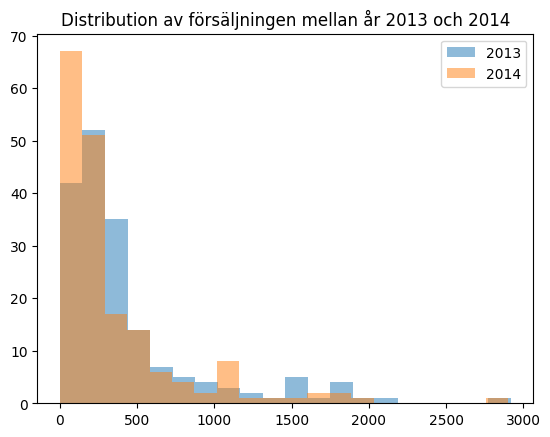

In [40]:
import matplotlib.pyplot as plt


# Plot distribution
plt.hist(combined_df['TotalSold_2013'], bins=20, alpha=0.5, label='2013') #bins är antal intervall som histogrammet ska delas in i. 
plt.hist(combined_df['TotalSold_2014'], bins=20, alpha=0.5, label='2014')
plt.legend()
plt.title('Distribution av försäljningen mellan år 2013 och 2014')
plt.show()


#### Det ser ut som att det såldes fler dyra produkter under 2013 och fler billiga produkter under 2014. Detta kan tyda på att det inte är företagets fel stt de sålde färre under 2014 utan snarare externa faktorer såsom ekonomisk osäkerhet hos kunderna. Datan är rejält sned - en högerskev fördelning, där huvuddelen av datapunkterna samlas nära det lägre intervallet och sedan har man en lång svans åt höger. Eftersom t-testet förutsätter normalfördelad data, är en loggning av data eller ett icke-parametriskt test är mer passande.

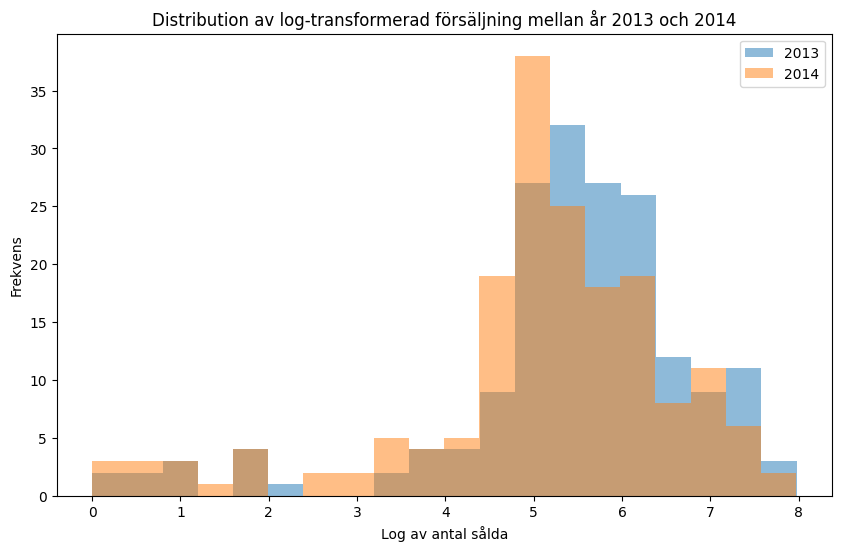

In [35]:
import numpy as np

# Filter out rows with zero or negative sales before log transformation
combined_df = combined_df[(combined_df['TotalSold_2013'] > 0) & (combined_df['TotalSold_2014'] > 0)]

# Log transform the filtered data
combined_df['TotalSold_2013_log'] = np.log(combined_df['TotalSold_2013'])
combined_df['TotalSold_2014_log'] = np.log(combined_df['TotalSold_2014'])

# Plot distribution of log-transformed data
plt.figure(figsize=(10, 6))
plt.hist(combined_df['TotalSold_2013_log'], bins=20, alpha=0.5, label='2013')
plt.hist(combined_df['TotalSold_2014_log'], bins=20, alpha=0.5, label='2014')
plt.xlabel('Log av antal sålda')
plt.ylabel('Frekvens')
plt.legend()
plt.title('Distribution av log-transformerad försäljning mellan år 2013 och 2014')
plt.show()


#### nu kan jag göra en t-test för att se om det finns en signifikant skillnad i försäljningen mellan år 2013 och 2014.


#### t-test är tvåsidigt för att vi inte vet om försäljningen ökade eller minskade.
3### ttest_ind jämför medelvärden och variation mellan två oberoende grupper

In [39]:
from scipy.stats import ttest_ind
# explicitely state that confidence 0.95

t_stat, p_value = ttest_ind(combined_df['TotalSold_2013_log'], combined_df['TotalSold_2014_log'])

print(f"T-statistik: {t_stat:.2f}, P-värde: {p_value:.2f}")


T-statistik: 2.11, P-värde: 0.04



#### Här med hjälp av scipy inbyggda statistiska funktioner kan vi se att p-värdet är mindre än 0.05 så vi kan förkasta nollhypotesen om att det inte finns skillnad i medelvärderna för försäljningen mellan år 2013 och 2014. Då accepterar vi en mothypotesen om att det finns en statistiskt signifikant skillnad i medelvärderna för försäljningen mellan år 2013 och 2014.



# Del 3.

#### Executive summary: År 2013 ökade försäljningen mycket och nådde över 40 miljoner USD. År 2014 halverades försäljningen, troligen för att inga nya produkter kom ut, vilket gjorde att företaget stagnerade. Under 2013 sålde dyra produkter bäst, men 2014 köpte kunder mest billigare saker, kanske på grund av ändrad ekonomi.

#### Nollhypotesen om att det inte finns någon skillnad i försäljning mellan 2013 och 2014 förkastades, och mothypotesen accepterades. Det finns en signifikant skillnad i försäljningen mellan dessa år, vilket ytterligare stöder tanken att externa faktorer (priser, konkurrens, kundernas ekonomi) kan ha påverkat resultaten. För att kunna bättre förstå varför försäljningen sjönk under 2014 kan vi ta i mer data om trender i världen under 2014 som kumde påverka hur folk handlar.

#### Företaget kan öka sin försäljning genom att satsa på populära produkter som Logo Cap och Long-Sleeve Logo Jersey, eftersom enligt försäljningsdata är profilkläder efterfrågade. Det är också viktigt att lansera nya produkter regelbundet och följa vad kunderna vill ha. Att placera ett lager i Southwest USA kan vara smart eftersom många kunder bor där.

## Muntlig presentation: Den 3 januari 2025.

Jag hoppade över självutvärderingen. *